6. In this exercise, you will further analyze the `Wage` data set considered throughout this chapter.

In [7]:
library("ISLR2")
library("skimr")
library("ggplot2")
library("splines")
library("gam")
library("akima")
library("boot")

In [3]:
head(Wage)

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>
231655,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.04315
86582,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.47602
161300,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.98218
155159,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.68529
11443,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.04315
376662,2008,54,2. Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,4.845098,127.11574


In [4]:
skim(Wage)

── Data Summary ────────────────────────
                           Values
Name                       Wage  
Number of rows             3000  
Number of columns          11    
_______________________          
Column type frequency:           
  factor                   7     
  numeric                  4     
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique
1 maritl                0             1 FALSE          5
2 race                  0             1 FALSE          4
3 education             0             1 FALSE          5
4 region                0             1 FALSE          1
5 jobclass              0             1 FALSE          2
6 health                0             1 FALSE          2
7 health_ins            0             1 FALSE          2
  top_counts                            
1 2. : 2074, 1. : 648, 4. : 204, 5. : 55

In [5]:
colSums(is.na(Wage))

year        age     maritl       race  education     region   jobclass 
         0          0          0          0          0          0          0 
    health health_ins    logwage       wage 
         0          0          0          0

(a) Perform polynomial regression to predict `wage` using `age`. 
Use cross-validation to select the optimal degree $d$ for the polynomial. 
What degree was chosen, and how does this compare to the results of hypothesis testing using ANOVA? 
Make a plot of the resulting polynomial fit to the data.

We are going to perform the fit testing up to 10 degrees polynomials, using 10-fold cross-validation.

In [8]:
set.seed(1)
NUM_POLY <- 10
cv_error <- numeric(length = NUM_POLY)
for (i in seq(NUM_POLY)) {
    glm_fit <- glm(wage ~ poly(age, i), data = Wage)
    cv_error[i] <- cv.glm(Wage, glm_fit, K = 10)$delta[1]
}
print(round(cv_error, 2))

 [1] 1676.83 1600.76 1598.40 1595.65 1594.98 1596.06 1594.30 1598.13 1593.91
[10] 1595.95


In [37]:
d_cv <- which.min(cv_error)
cv_error[d_cv]

[1] 1593.913

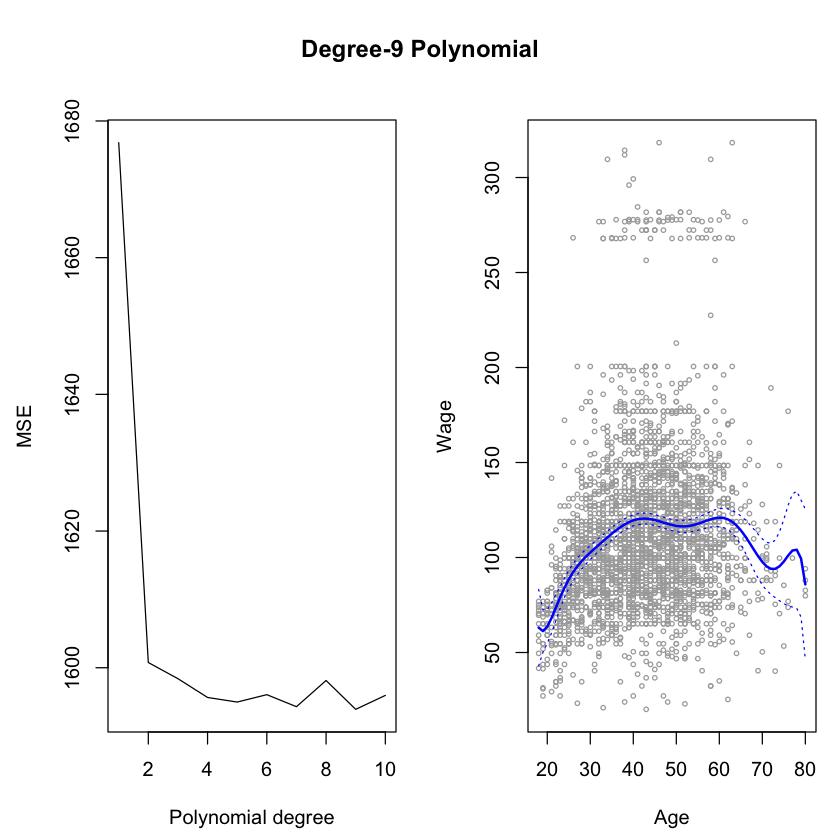

In [40]:
par(mfrow = c(1, 2), mar = c(4.5, 4.5, 1, 1), oma = c(0, 0, 4, 0))

plot(
    cv_error,
    type = "l",
    xlab = "Polynomial degree",
    ylab = "MSE"
)

age_lims <- range(Wage$age)
age_grid <- seq(from = age_lims[1], to = age_lims[2])

glm_fit <- glm(wage ~ poly(age, d_cv), data = Wage)
preds <- predict(glm_fit, newdata = list(age = age_grid), se = T)
se_bands <- cbind(
    preds$fit + 2.0 * preds$se.fit,
    preds$fit - 2.0 * preds$se.fit
)

plot(Wage$age, Wage$wage, xlim = age_lims, cex = .5, col = "darkgrey", xlab = "Age", ylab = "Wage")
title("Degree-9 Polynomial", outer = T)
lines(age_grid, preds$fit, lwd = 2, col = "blue")
matlines(age_grid, se_bands, lwd = 1, col = "blue", lty = 3)

The 9th degree polynomial has the smaller MSE. However, there is little evidence that using a degree higher than 2 is adequate. Let's see the ANOVA analysis. There seems to be evidence of overfitting also on the boundaries with the 9th polynomial degree.

In [54]:
fit_anova <- list()
for (i in seq(NUM_POLY)) {
    fit_anova[[i]] <- lm(wage ~ poly(age, i), data = Wage)
}

In [55]:
print(anova(
    fit_anova[[1]],
    fit_anova[[2]],
    fit_anova[[3]],
    fit_anova[[4]],
    fit_anova[[5]],
    fit_anova[[6]],
    fit_anova[[7]],
    fit_anova[[8]],
    fit_anova[[9]],
    fit_anova[[10]]
))

Analysis of Variance Table

Model  1: wage ~ poly(age, i)
Model  2: wage ~ poly(age, i)
Model  3: wage ~ poly(age, i)
Model  4: wage ~ poly(age, i)
Model  5: wage ~ poly(age, i)
Model  6: wage ~ poly(age, i)
Model  7: wage ~ poly(age, i)
Model  8: wage ~ poly(age, i)
Model  9: wage ~ poly(age, i)
Model 10: wage ~ poly(age, i)
   Res.Df     RSS Df Sum of Sq        F    Pr(>F)    
1    2998 5022216                                    
2    2997 4793430  1    228786 143.7638 < 2.2e-16 ***
3    2996 4777674  1     15756   9.9005  0.001669 ** 
4    2995 4771604  1      6070   3.8143  0.050909 .  
5    2994 4770322  1      1283   0.8059  0.369398    
6    2993 4766389  1      3932   2.4709  0.116074    
7    2992 4763834  1      2555   1.6057  0.205199    
8    2991 4763707  1       127   0.0796  0.777865    
9    2990 4756703  1      7004   4.4014  0.035994 *  
10   2989 4756701  1         3   0.0017  0.967529    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


The $p$-value of the anova analysis suggests that the 9th degree polynomial is significant to model the data.
in general these results are consistent with those of cross-validation.

(b) Fit a step function to predict `wage` using `age`, and perform cross-validation to choose the optimal number of cuts. 
Make a plot of the fit obtained.

In [81]:
set.seed(1)
MAX_NUM_CUT <- 10
cv_error_cut <- numeric(length = MAX_NUM_CUT - 1)
for (i in 2:MAX_NUM_CUT) {
    Wage$tmp <- cut(Wage$age, i) # this way cut is inside the df otherwise cv.glm complains
    fit <- glm(wage ~ tmp, data = Wage)
    cv_error_cut[i] <- cv.glm(Wage, fit, K = 10)$delta[1]
}
cv_error_cut <- cv_error_cut[2:10]
print(round(cv_error_cut, 2))

[1] 1734.49 1684.27 1635.55 1632.08 1623.42 1615.00 1601.32 1613.95 1606.33


In [83]:
d_cut <- which.min(cv_error_cut)
cv_error_cut[d_cut]

[1] 1601.318

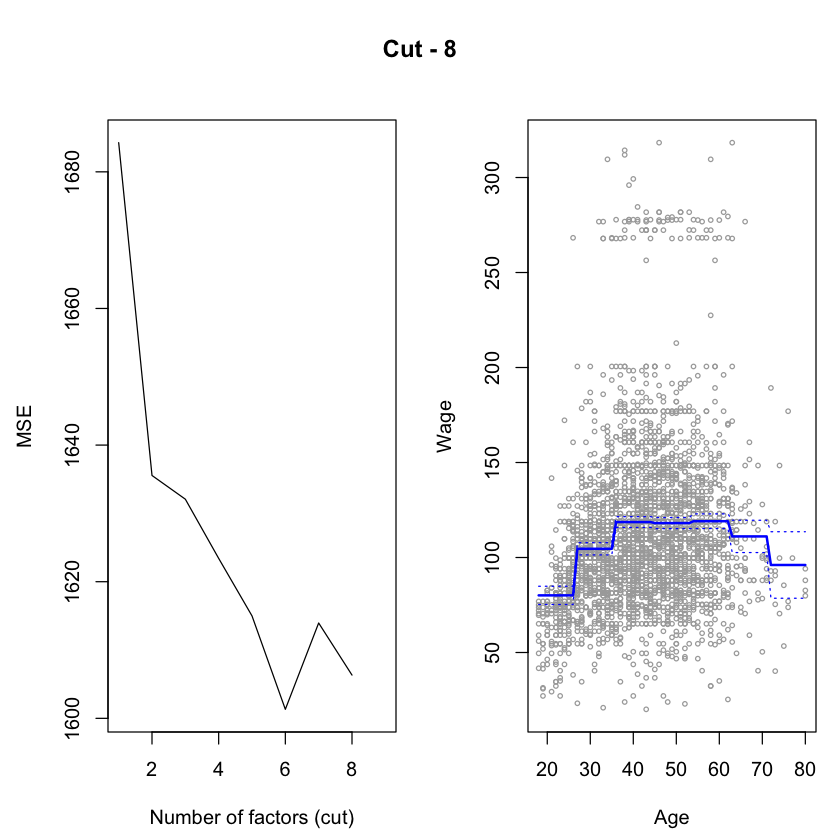

In [84]:
par(mfrow = c(1, 2), mar = c(4.5, 4.5, 1, 1), oma = c(0, 0, 4, 0))

plot(
    cv_error_cut[2:10],
    type = "l",
    xlab = "Number of factors (cut)",
    ylab = "MSE"
)

age_lims <- range(Wage$age)
age_grid <- seq(from = age_lims[1], to = age_lims[2])

glm_fit <- glm(wage ~ cut(age, d_cut), data = Wage)
preds <- predict(glm_fit, newdata = list(age = age_grid), se = T)
se_bands <- cbind(
    preds$fit + 2.0 * preds$se.fit,
    preds$fit - 2.0 * preds$se.fit
)

plot(Wage$age, Wage$wage, xlim = age_lims, cex = .5, col = "darkgrey", xlab = "Age", ylab = "Wage")
title("Cut - 8", outer = T)
lines(age_grid, preds$fit, lwd = 2, col = "blue")
matlines(age_grid, se_bands, lwd = 1, col = "blue", lty = 3)